# Greek Mythology Project: Code File

In this document you will find the following: <br>
- [Necessary imports](#Necessary-imports)
- [Data Acquisition](#Data-Acquisition)
- [Preprocessing](#Preprocessing)
- [Data Exploration](#Data-Exploration) 
- [Word2Vec model](#Word2Vec-model) + [Co-occurrences](#Co-occurrences)
- [Data Visualisation](#Data-Visualisation)

## Necessary imports

In [1]:
import numpy as np
import nltk
import json
import urllib
import requests
import matplotlib.pyplot as plt
import gensim.downloader as api
from tabulate import tabulate
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from collections import Counter
from urllib.request import urlopen
from bs4 import BeautifulSoup
from sklearn.decomposition import PCA

In [2]:
with open('mortaldict.json', 'r') as f:
    mortaldict = json.load(f)
    
with open('goddict.json', 'r') as f:
    goddict = json.load(f)

## Data Acquisition

All our texts will be extracted from the website [theoi](https://www.theoi.com/). It contains almost all of the original texts of Greek Mythology translated into English. In this project, we have decided to extract some of the more popular stories, namely; [The Odysee](#Homer-Odysee) , [The Iliad](#The-Iliad) , [The Fall of Troy](#The-Fall-of-Troy) , and the [Ovid Metamorphoses](#Ovid-Metamorphosis).

#### The Odysee

In [3]:
Odysee_URL = "https://www.theoi.com/Text/HomerOdyssey1.html"
Odysee_page = requests.get(Odysee_URL)
Odysee_soup = BeautifulSoup(Odysee_page.content, "html.parser")

#visual part of text
Odysee_soup.get_text()[4000:4500]

"ather of gods and men was first to speak, for in his heart he thought of noble Aegisthus, whom far-famed Orestes, Agamemnon's son, had slain. Thinking on him he spoke among the immortals, and said: “Look you now, how ready mortals are to blame the gods. It is from us, they say, that evils come, but they even of themselves, through their own blind folly, have sorrows beyond that which is ordained. Even as now Aegisthus, beyond that which was ordained, took to himself the wedded wife of the son of"

#### The Iliad

In [4]:
Iliad_URL = "https://www.theoi.com/Text/HomerIliad1.html"
Iliad_page = requests.get(Iliad_URL)
Iliad_soup = BeautifulSoup(Iliad_page.content, "html.parser")

#visual part of text
Iliad_soup.get_text()[4000:4500]

'not protect you. Her I will not set free. Sooner shall old age come upon her in our house, in Argos, far from her native land, as she walks to and fro before the loom and serves my bed. But go, do not anger me, that you may return the safer."\n[33] So he spoke, and the old man was seized with fear and obeyed his word. He went forth in silence along the shore of the loud-resounding sea, and earnestly then, when he had gone apart, the old man prayed\xa0to the lord Apollo, whom fair-haired Leto bore: "'

#### The Fall of Troy

In [5]:
Troy_URL = "https://www.theoi.com/Text/QuintusSmyrnaeus1.html"
Troy_page = requests.get(Troy_URL)
Troy_soup = BeautifulSoup(Troy_page.content, "html.parser")

#visual part of text
Troy_soup.get_text()[4000:4500]

" she mid that charging host. Clonie was there, Polemusa, Derinoe, Evandre, and Antandre, and Bremusa, Hippothoe, dark-eyed Harmothoe, Alcibie, Derimacheia, Antibrote, and Thermodosa glorying with the spear. All these to battle fared with warrior-souled Penthesileia: even as when descends Dawn from Olympus' crest of adamant, Dawn, heart-exultant in her radiant steeds amidst the bright-haired Hours; and o'er them all, how flawless-fair soever these may be, her splendour of beauty glows pre-eminent"

#### Ovid Metamorphosis

In [6]:
OvidM_URL = "https://www.theoi.com/Text/OvidMetamorphoses1.html"
OvidM_page = requests.get(OvidM_URL)
OvidM_soup = BeautifulSoup(OvidM_page.content, "html.parser")

#visual part of text
OvidM_soup.get_text()[4000:4500]

'aste. It was a rude and undeveloped mass, that nothing made except a ponderous weight; and all discordant elements confused, were there congested in a shapeless heap. As yet the sun afforded earth no light, nor did the moon renew her crescent horns; the earth was not suspended in the air exactly balanced by her heavy weight. Not far along the margin of the shores had Amphitrite stretched her lengthened arms,—for all the land was mixed with sea and air. The land was soft, the sea unfit to sail, t'

Now that we have the starting pages of all 4 stories, we will have to find a way to extract the other chapters which are linked in the home pages.  As seen in the code below, the links to the other chapters (called BOOKS), always have the following format: <br> 
< a href="HomerOdyssey1.html">BOOK 1</a >, <br>
< a href="HomerOdyssey2.html">BOOK 2</a >,


In [7]:
Odysee_soup.find_all('a')

[<a class="navbar-brand" href="https://www.theoi.com/Library.html">Theoi Project - Classical Texts Library</a>,
 <a href="../Library.html">LIBRARY HOME</a>,
 <a href="https://www.theoi.com/">GREEK MYTHOLOGY</a>,
 <a aria-expanded="false" aria-haspopup="true" class="dropdown-toggle" data-toggle="dropdown" href="#" role="button">GREEK GODS<span class="caret"></span></a>,
 <a href="../greek-mythology/olympian-gods.html">Olympian Gods</a>,
 <a href="../greek-mythology/primeval-gods.html">Primordial Gods</a>,
 <a href="../greek-mythology/titans.html">Titan Gods</a>,
 <a href="../greek-mythology/sky-gods.html">Sky Gods</a>,
 <a href="../greek-mythology/sea-gods.html">Sea Gods</a>,
 <a href="../greek-mythology/rustic-gods.html">Rustic Gods</a>,
 <a href="../greek-mythology/underworld-gods.html">Underworld Gods</a>,
 <a href="../greek-mythology/personifications.html">Daemones-Spirits</a>,
 <a href="../greek-mythology/nymphs.html">Nymphs</a>,
 <a href="../greek-mythology/greek-gods.html">more &

Now that we know what we are looking for, we will create a list which has all the links to the different chapters which we can then loop through later.  

In [8]:
Websites = []

#Odysee
for link in Odysee_soup.find_all('a'):
    if "HomerOdyssey" in link.get('href'):
        Websites.append("https://www.theoi.com/Text/" + link.get('href'))
        
#Iliad
for link in Iliad_soup.find_all('a'):
    if "HomerIliad" in link.get('href'):
        Websites.append("https://www.theoi.com/Text/" + link.get('href'))
        
#Troy
for link in Troy_soup.find_all('a'):
    if "QuintusSmyrnaeus" in link.get('href'):
        Websites.append("https://www.theoi.com/Text/" + link.get('href'))
        
#Ovid-Metamorphosis
for link in OvidM_soup.find_all('a'):
    if link.get('href') == None:
        continue
    elif "OvidMetamorphoses" in link.get('href') and not '#' in link.get('href'):
        Websites.append("https://www.theoi.com/Text/" + link.get('href'))    

#visualise all the chapters
for web in Websites:
    print(web)

https://www.theoi.com/Text/HomerOdyssey1.html
https://www.theoi.com/Text/HomerOdyssey2.html
https://www.theoi.com/Text/HomerOdyssey3.html
https://www.theoi.com/Text/HomerOdyssey4.html
https://www.theoi.com/Text/HomerOdyssey5.html
https://www.theoi.com/Text/HomerOdyssey6.html
https://www.theoi.com/Text/HomerOdyssey7.html
https://www.theoi.com/Text/HomerOdyssey8.html
https://www.theoi.com/Text/HomerOdyssey9.html
https://www.theoi.com/Text/HomerOdyssey10.html
https://www.theoi.com/Text/HomerOdyssey11.html
https://www.theoi.com/Text/HomerOdyssey12.html
https://www.theoi.com/Text/HomerOdyssey13.html
https://www.theoi.com/Text/HomerOdyssey14.html
https://www.theoi.com/Text/HomerOdyssey15.html
https://www.theoi.com/Text/HomerOdyssey16.html
https://www.theoi.com/Text/HomerOdyssey17.html
https://www.theoi.com/Text/HomerOdyssey18.html
https://www.theoi.com/Text/HomerOdyssey19.html
https://www.theoi.com/Text/HomerOdyssey20.html
https://www.theoi.com/Text/HomerOdyssey21.html
https://www.theoi.com/

Now that we have all the html links to the chapters of the books we want to use, we will scrape the text off them and combine it all into one list. This list will be used for the rest of the analyses.

In [9]:
full_text = []
for link in Websites:
    p = requests.get(link)
    s = BeautifulSoup(p.content, "html.parser")
    full_text.append(s.get_text())
    
    #check which books have been printed
    print('Retrieved ', s.title) 

Retrieved  <title>HOMER, ODYSSEY BOOK 1 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 2 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 3 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 4 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 5 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 6 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 7 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 8 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 9 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 10 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 11 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK 12 - Theoi Classical Texts Library</title>
Retrieved  <title>HOMER, ODYSSEY BOOK

## Preprocessing

Now, we will preprocess the full_text. Firts, we split the data into sentences.

In [10]:
sentences = []
for par in full_text:
    
    # remove enters
    if par == '\n':
        continue
    
    # split paragraph into sentences
    senttemp = sent_tokenize(par)
    sentences = sentences +senttemp

print(sentences[100])

Come now, give ear, and hearken to my words.


Now, we tokenize the sentences. If the sentence consists of two words or less, we remove it since it won't contain much useful information. Also, this way we might be able to filter out as many chapter titles as possible.

In [11]:
words = []
for sent in sentences:
    
    # split sentence into words
    wordstemp = word_tokenize(sent)
    
    # if sentence is smaller than 2 words remove it
    if len(wordstemp) <= 2:
        continue
        
    words.append(wordstemp)
    
print(words[100])

['On', 'the', 'morrow', 'call', 'to', 'an', 'assembly', 'the', 'Achaean', 'lords', ',', 'and', 'speak', 'out', 'thy', 'word', 'to', 'all', ',', 'and', 'let', 'the', 'gods', 'be', 'thy', 'witnesses', '.']


Now, we PoS tag the data, so that lemmatization is easier, and names of characters can be identified more easily. We filter out punctuation, since these characters are unnecessary for our research.

In [12]:
tagged = []
for sent in words:
    senttagged = nltk.pos_tag(sent)
    tagged.append(senttagged)

tagged_filtered = []
for sent in tagged:
    sentls = []
    
    # if word is punctuation, remove it
    for wordtag in sent:
        if wordtag[1] in ['.', ',', ':', '--', '$', '(', ')'] or wordtag[0] in ['“', '”', '<', '>']:
            continue
            
        else: sentls.append(wordtag)
    tagged_filtered.append(sentls)
        
print(tagged_filtered[100])

[('On', 'IN'), ('the', 'DT'), ('morrow', 'NN'), ('call', 'NN'), ('to', 'TO'), ('an', 'DT'), ('assembly', 'NN'), ('the', 'DT'), ('Achaean', 'NNP'), ('lords', 'NNS'), ('and', 'CC'), ('speak', 'VB'), ('out', 'RP'), ('thy', 'JJ'), ('word', 'NN'), ('to', 'TO'), ('all', 'DT'), ('and', 'CC'), ('let', 'VB'), ('the', 'DT'), ('gods', 'NNS'), ('be', 'VB'), ('thy', 'JJ'), ('witnesses', 'NNS')]


Next, we lemmatize the dataset. Since the PoS tagset of WordNet and NLTK are different, we have to account for this. If the tag of the word does not exist in the lemmatizer tagset, we lemmatize the word without the PoS tag as reference.

In [13]:
# Reference for lemmatizing: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python

lemmatizer = WordNetLemmatizer()

lemmatized = []
for sent in tagged_filtered:
    
    sentls = []
    
    # compare tags from WordNet to those from nltk
    for wordtag in sent:
        tag = ''
        if wordtag[1][0:2] ==  'NN':
            tag =  'n'
        elif wordtag[1][0:2] ==  'VB':
            tag =  'v'
        elif wordtag[1][0:2] ==  'JJ':
            tag =  'a'
        elif wordtag[1][0:2] ==  'RB':
            tag =  'r'
        
        # use postag if it exists in the WordNetlemmatizer
        if tag == '': lemma = lemmatizer.lemmatize(wordtag[0])
        else: lemma = lemmatizer.lemmatize(wordtag[0], pos=tag)
        
        sentls.append([lemma, wordtag[1]])
    lemmatized.append(sentls)
    
print(lemmatized[100])

[['On', 'IN'], ['the', 'DT'], ['morrow', 'NN'], ['call', 'NN'], ['to', 'TO'], ['an', 'DT'], ['assembly', 'NN'], ['the', 'DT'], ['Achaean', 'NNP'], ['lord', 'NNS'], ['and', 'CC'], ['speak', 'VB'], ['out', 'RP'], ['thy', 'JJ'], ['word', 'NN'], ['to', 'TO'], ['all', 'DT'], ['and', 'CC'], ['let', 'VB'], ['the', 'DT'], ['god', 'NNS'], ['be', 'VB'], ['thy', 'JJ'], ['witness', 'NNS']]


Next, we go through the data and print all the proper nouns that aren't in the dictionaries. If they are not and they refer to names of characters that are either Olympian gods or mortals, we add them to the dictionaries in the file characterdicts.ipynb. We do this only for names that occur at least 10 times in the book, since adding all names is not realistic. The below code prints the proper nouns (or words that were classified as such) that we didn't add to the dictionary. As can be seen, all of these are either not names, names of people who aren't part of mythology (such as authors of the texts), or children of gods (in which case we left them out, since they are somewhere between god and mortal).

In [14]:
# Reference for sorting dictionary: https://www.edureka.co/blog/sort-dictionary-by-value-in-python/

# dictionaries of names not in goddict or mortaldict
non_occuring = {}
non_occuring_min10 = {}

for sent in lemmatized:
    for wordtag in sent:
    
        # Only look at proper nouns
        if wordtag[1] == 'NNP':

            # Binary to indicate if the word has been found
            filled_in = 0

            # Go through mortaldict
            for idx, vals in enumerate(mortaldict.values()):
                if wordtag[0] in vals[0]:
                    filled_in = 1
                    break

            # If word hasn't been found in mortaldict, go through goddict
            if filled_in == 0:
                for idx, vals in enumerate(goddict.values()):
                    if wordtag[0] in vals[0]:
                        filled_in = 1
                        break

            # Print word if it hasn't been found at all
            if filled_in == 0:
                if wordtag[0] in non_occuring.keys():
                    non_occuring[wordtag[0]] += 1
                else: non_occuring[wordtag[0]] = 1

# fill in dict with all non-occurring words that appear 10 or more times
for key in non_occuring.keys():
    if non_occuring[key] >= 10:
        non_occuring_min10[key] = non_occuring[key]

# print dict
for key in sorted(non_occuring_min10.keys()):
       print("%s: %s" % (key, non_occuring_min10[key]))

A: 190
A-Z: 81
A.: 67
AND: 57
ARTICLES: 81
Aaron: 81
Achaea: 40
Achaean: 56
Achaeans: 26
Achelous: 38
Achilleid: 81
Achilles: 850
Actor: 12
Aeacus: 100
Aegeus: 28
Aeneid: 81
Aeolus: 19
Aesacus: 21
Aeschylus: 567
Aeson: 23
Against: 83
Age: 11
Aglauros: 25
Ah: 100
Aiantes: 18
Alas: 30
Alcman: 81
Alexander: 49
Alexandra: 81
Alpheus: 22
Althaea: 21
Amazon: 20
Amazons: 13
Anaxarete: 18
Antenor: 32
Antimachus: 10
Antinous: 58
Apollodorus: 81
Apollonius: 81
Aratus: 81
Arethusa: 24
Argive: 76
Argives: 121
Argonautica: 162
Argos: 60
Argus: 19
Armour: 25
Arms: 15
Asius: 20
Astronomica: 81
Athamas: 22
Athens: 17
Atlas: 32
Atsma: 81
Attis: 17
Aulis: 22
Aurora: 23
Ay: 17
Aye: 65
BESTIARY: 81
BOOK: 1796
BROOKES: 16
BY: 81
Barring: 25
Battefield: 25
Battle: 51
Battlefield: 350
Battles: 30
Battus: 18
Baucis: 22
Be: 20
Bearers: 81
Beggar: 50
Beguiling: 25
Behold: 13
Bion: 81
Boar: 17
Body: 25
Book: 81
Boreas: 31
Bound: 81
Byblis: 25
CLASSICAL: 81
CONTENTS: 81
Cadmus: 58
Caeneus: 31
Caesar: 24
Callimach

## Data exploration

Now to explore the data, and see whether the dictionaries above work as intended. First, we go through the texts, and count how many times a certain name is mentioned.

In [15]:
i = 0
for idx, sent in enumerate(lemmatized):
    for idx2, wordtag in enumerate(sent):
        word = wordtag[0]
        tag = wordtag[1]

        if tag == 'NNP':

            # Binary to indicate if the word has been found
            filled_in = 0

            # Go through mortaldict
            for idx3, vals in enumerate(mortaldict.values()):
                if word in vals[0]:
                    filled_in = 1
                    mortaldict[str(idx3)][1] += 1
                    lemmatized[idx][idx2][1] = 'NNPm'
                    i += 1
                    break

            # If word hasn't been found in mortaldict, go through goddict
            if filled_in == 0:
                for idx4, vals in enumerate(goddict.values()):
                    if word in vals[0]:
                        filled_in = 1
                        goddict[str(idx4)][1] += 1
                        lemmatized[idx][idx2][1] = 'NNPg'
                        i += 1
                        break

Below we print the amounts of times mortals and gods are mentioned. Note that in reality this number is a bit higher because we are not looking at all mortals and all gods. While mortals are named more often, both gods and mortals are named enough times to be able to do a meaningful analysis.

In [16]:
summortals = 0
sumgods = 0

for mval in mortaldict.values():
    summortals += mval[1]
    
for gval in goddict.values():
    sumgods += gval[1]
    
print('Total amount of mortal names: ', summortals)
print('Total amount of god names: ', sumgods)

Total amount of mortal names:  8292
Total amount of god names:  3926


Next, we plot the 20 most common names for both mortals and gods. 

In [17]:
# Reference for sorting dict: https://www.geeksforgeeks.org/python-sort-list-according-second-element-sublist/

sortm = list(mortaldict.values())
sortm.sort(key = lambda x: x[1])
sortm.reverse()

sortg = list(goddict.values())
sortg.sort(key = lambda x: x[1])
sortg.reverse()

In [18]:
# seperate lists of names and their counts for plotting
mnames = [name[0][0] for name in sortm]
mcounts = [count[1] for count in sortm]

gnames = [name[0][0] for name in sortg]
gcounts = [count[1] for count in sortg]

As can be seen in the graphs, the most common names make sense considering the original texts. The main characters of for example the Iliad and Odyssee occur most often, and the most important gods are named the most.

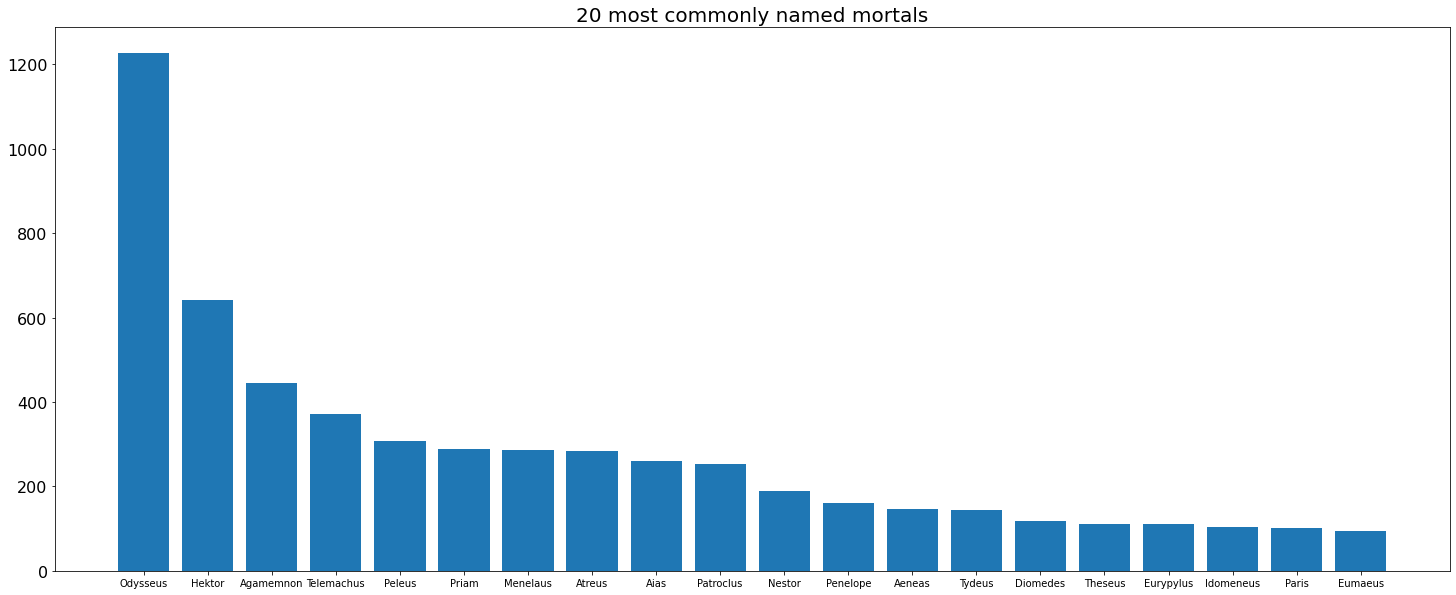

In [19]:
plt.figure(figsize=(25, 10))
plt.bar(mnames[0:20], mcounts[0:20], color='tab:blue')
plt.title('20 most commonly named mortals', fontsize=20)
plt.yticks(fontsize=16)
plt.show()

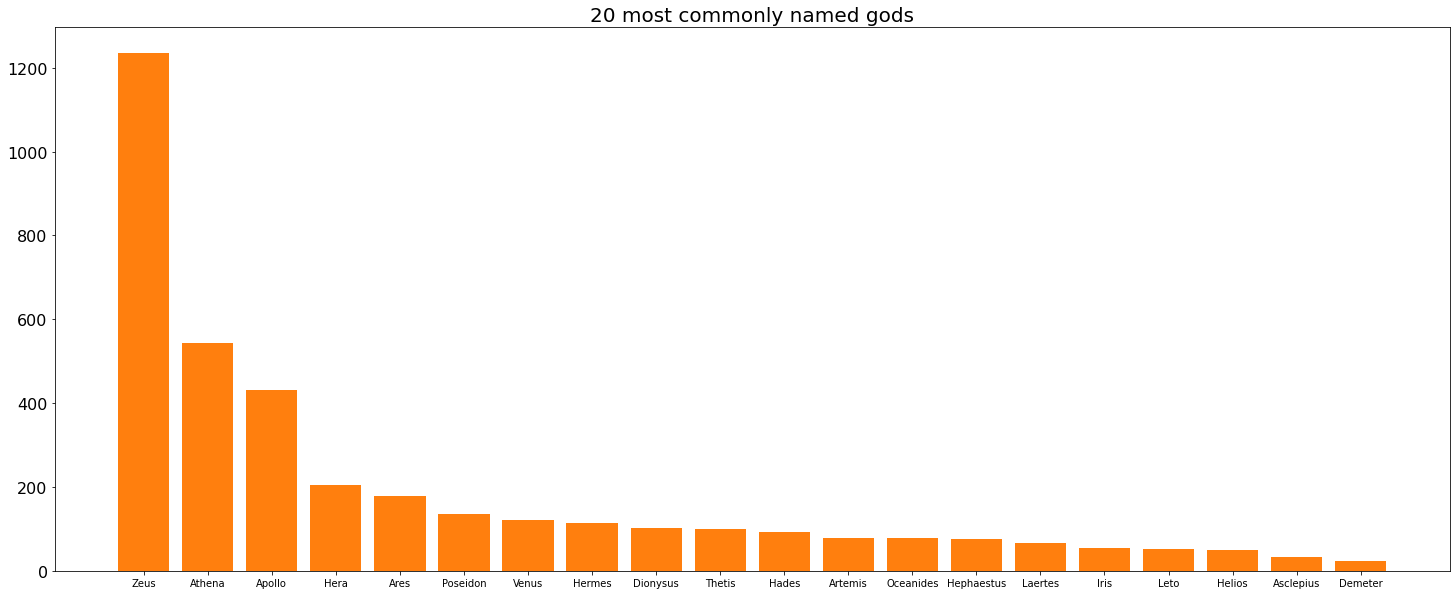

In [20]:
plt.figure(figsize=(25, 10))
plt.bar(gnames[0:20], gcounts[0:20], color='tab:orange')
plt.title('20 most commonly named gods', fontsize =20)
plt.yticks(fontsize=16)
plt.show()

Next, we retrieve the context of each name. This refers to the five words before and after the character. We chose quite a large context considering we are looking at adjectives and adverbs around a name, but this is because in the translations there are often many descriptions around a character which we do not want to leave out.

In [21]:
# list of names and their contexts
name_cons = []

for idx, sent in enumerate(lemmatized):
    for idx2, wordtag in enumerate(sent):    
        word = wordtag[0]
        tag = wordtag[1]
        
        # if target word is a name, save its context
        if tag == 'NNPm' or tag == 'NNPg':
            context = sent[max(0, idx2-5):idx2] + sent[idx2+1: min(len(sent), idx2+5)]
            name_cons.append([wordtag, context])

print(name_cons[100])

[['Athena', 'NNPg'], [['So', 'NNP'], ['speak', 'VBD'], ['the', 'DT'], ['goddess', 'NN'], ['flashing-eyed', 'JJ'], ['and', 'CC'], ['depart', 'VBD'], ['fly', 'VBG'], ['upward', 'RB']]]


We check whether there are enough adjectives and adverbs in the context of the names to be able to perform the analysis. 

In [22]:
# integers to keep track of number of adjectives and adverbs around mortals and gods
advcountm = 0
adjcountm = 0
advcountg = 0
adjcountg = 0

# counter to retrieve most common adjectives and adverbs
adjcounter = Counter()

for namecon in name_cons:
    name = namecon[0]
    con = namecon[1]
    
    if name[1] == 'NNPm':
        for wordtag in con:
            if wordtag[1][0:2] == 'RB':
                advcountm += 1
                adjcounter[wordtag[0]] += 1
                
            elif wordtag[1][0:2] == 'JJ':
                adjcountm += 1
                adjcounter[wordtag[0]] += 1
                
    elif name[1] == 'NNPg':
        for wordtag in con:
            if wordtag[1][0:2] == 'RB':
                advcountg += 1
                adjcounter[wordtag[0]] += 1
                
            elif wordtag[1][0:2] == 'JJ':
                adjcountg += 1
                adjcounter[wordtag[0]] += 1
                
print('There are ', advcountm, ' adverbs, and ', adjcountm, ' adjectives around names of mortals.')
print('There are ', advcountg, ' adverbs, and ', adjcountg, ' adjectives around names of gods.')

There are  3312  adverbs, and  3524  adjectives around names of mortals.
There are  1518  adverbs, and  1973  adjectives around names of gods.


We consider these as enough adjectives and adverbs to perform the analysis. We will also look at the most common adjectives and adverbs to see whether there are some that are not useful for this analysis. In the section where we look at co-occurrences, we remove the words from this list that do not tell anything about a character, like 'then' or 'so'. This list of words to remove can be seen below.

In [23]:
print(adjcounter.most_common(30))

[('Then', 545), ('not', 398), ('even', 340), ('goodly', 266), ('[', 220), ('now', 217), ('then', 206), ('glorious', 195), ('many', 188), ('great', 187), ('first', 152), ('so', 150), ('So', 143), ('unto', 127), ('other', 116), ('thou', 110), ('good', 109), ('flashing-eyed', 103), ('again', 100), ('dear', 99), ('verily', 97), ('old', 85), ('thy', 79), ('yet', 72), ('ever', 72), (']', 72), ('thus', 69), ('mighty', 61), ('far', 60), ('long', 60)]


In [24]:
remove = ["Then", "then", "[", "]", "thy", "thou", "many", "even", "not", "now", "So", "so", 
          "thou", "ever", "other", "unto", "yet", "such", "here", "again", "there", "more", 
          "too", "such", "thus", "as", "ye", "also", "once", "thee", "far", "back", "Now", 
          "indeed", "most", "no", "away", "near", "most", "Most", "already", "only", "near"]

## Word2Vec model

First, we will implement the Word2Vec model to see whether words around mortals are different from those around gods. Lemmatized_replace is a list of the PoS tagged data, where each name of a mortal or god is replaced by MORTALNAME or GODNAME. This way, we can clearly see the difference between gods and mortals, without having to go through all names of gods and mortals and seeing what words are most similar to them. 

In [25]:
lemmatized_replace = []

for sent in lemmatized:
    sentls = []
    for wordtag in sent:
        
        # if name is mortal, replace with MORTALNAME
        if wordtag[1] == 'NNPm': 
            sentls.append(['MORTALNAME', 'NNPm'])
            
        # if name is god, replace with GODNAME
        elif wordtag[1] == 'NNPg':
            sentls.append(['GODNAME', 'NNPg'])
            
        # otherwise do nothing
        else: sentls.append(wordtag)
            
    lemmatized_replace.append(sentls)

print(lemmatized_replace[100])

[['On', 'IN'], ['the', 'DT'], ['morrow', 'NN'], ['call', 'NN'], ['to', 'TO'], ['an', 'DT'], ['assembly', 'NN'], ['the', 'DT'], ['Achaean', 'NNP'], ['lord', 'NNS'], ['and', 'CC'], ['speak', 'VB'], ['out', 'RP'], ['thy', 'JJ'], ['word', 'NN'], ['to', 'TO'], ['all', 'DT'], ['and', 'CC'], ['let', 'VB'], ['the', 'DT'], ['god', 'NNS'], ['be', 'VB'], ['thy', 'JJ'], ['witness', 'NNS']]


Below, we made a list of the text that can be used in the model. We filtered out any word that occurs in the 'remove' list and as such does not any meaningful value to the data. 

In [26]:
nofilt = []

for sent in lemmatized_replace:
    sentls = []
    for word in sent:
        
        #remove invaluable words
        if word[0] in remove:
            continue
            
        else:
            sentls.append(word[0]) 
            
    nofilt.append(sentls)

The parameters below were mostly taken from the notebook from week 5. We lowered the min_count, since we also want rare adjectives and adverbs to be taken into account. We also upped the amount of epochs, to prevent underfitting. However, we did not make this number too large, because overfitting should also be prevented. 

In [27]:
params = {
    'vector_size': 100, # dimension of embeddings
    'window': 4, # window -/+ before and after focus word
    'epochs': 10, # number of iterations over the corpus
    'min_count': 2, # filter on words whose frequency is below this count
    'sg': 0, # use the skip-gram (1) or the CBOW (0) mode. In class, we presented the CBOW (predict context given focus words). See optional materials for the skip-gram (predict focus given context)
    'negative': 5, # how many negative samples to use (see optional class contents too)
    'workers': 4, # how many cores to use
    'alpha': 0.05 # initial learning rate for SGD. This is lambda in the class notes
}
model = Word2Vec(nofilt, **params)

As can be seen below, the words that are most similar to gods are different from those that are most similar to mortals, but they contain many names and words that are not adjectives or adverbs. We now make lists with specifically the most similar adverbs and adjectives to gods and mortals.

In [28]:
for word in list(model.wv.most_similar('GODNAME', topn=10)):
    print(word)

('aegis', 0.630689263343811)
('beareth', 0.5648673176765442)
('Cronos', 0.5453126430511475)
('loud-thundering', 0.4975265860557556)
('Earth', 0.47177398204803467)
('throne', 0.4694960415363312)
('Olympus', 0.4672924280166626)
('afar', 0.4616108238697052)
('nymph', 0.45263636112213135)
('Calypso', 0.4510076940059662)


In [29]:
for word in list(model.wv.most_similar('MORTALNAME', topn=10)):
    print(word)

('Achilles', 0.5884064435958862)
('Sarpedon', 0.5816522836685181)
('Alexander', 0.574613630771637)
('Aeacus', 0.5528333783149719)
('Thrasymedes', 0.5400351881980896)
('Menoetius', 0.5088645815849304)
('Antenor', 0.47787898778915405)
('swineherd', 0.4699712097644806)
('Andraemon', 0.46212857961654663)
('Aeacid', 0.462062805891037)


In [30]:
lemmatized_replace_words = []
lemmatized_replace_tags = []

# create seperate lists of words and their tags
for sent in lemmatized_replace:
    for word in sent:
        lemmatized_replace_words.append(word[0])
        lemmatized_replace_tags.append(word[1])

# lists of most similar adjectives and adverbs to gods and mortals
similarg = []
similarm = []

for word in list(model.wv.most_similar('MORTALNAME', topn=3000)):
    tag = lemmatized_replace_tags[lemmatized_replace_words.index(word[0])]
    
    # keep word if it is an adjective or adverb
    if tag[0:2] in ['RB', 'JJ']:
        similarm.append([word[0], word[1]])

for word in list(model.wv.most_similar('GODNAME', topn=3000)):
    tag = lemmatized_replace_tags[lemmatized_replace_words.index(word[0])]
    
    # keep word if it is an adjective or adverb
    if tag[0:2] in ['RB', 'JJ']:
        similarg.append([word[0], word[1]])

Below are the lists of the most similar adverbs and adjectives. These lists seem to make sense, since adjectives that are only for gods (like Olympian) are most similar to gods, and the other way around (godlike is much more similar to mortals, which makes sense because a god won't be described as being 'godlike').

In [40]:
print('Most similar to gods:')
for word in similarg[:15]:
    print(word)
    
print('\n')

print('Most similar to mortals:')
for word in similarm[:15]:
    print(word)

Most similar to gods:
['loud-thundering', 0.4975265860557556]
['afar', 0.4616108238697052]
['borne', 0.40071970224380493]
['flashing-eyed', 0.390266478061676]
['fair-tressed', 0.3807802200317383]
['stainless', 0.37623468041419983]
['supreme', 0.3734374940395355]
['tasselled', 0.3733873963356018]
['heaven', 0.3696746230125427]
['gracious', 0.35158607363700867]
['fair-cheeked', 0.33978596329689026]
['keen-sighted', 0.3367964029312134]
['stout-hearted', 0.3366408944129944]
['aegis-bearing', 0.33496153354644775]
['crooked-counselling', 0.32553353905677795]


Most similar to mortals:
['much-enduring', 0.4121825397014618]
['valiant', 0.40612906217575073]
['great-souled', 0.3713684380054474]
['unmanly-souled', 0.3513787090778351]
['fair-haired', 0.34989863634109497]
['Aias', 0.3304297626018524]
['Peerless', 0.3288712203502655]
['alive', 0.3235081434249878]
['covetous', 0.3214995563030243]
['lordly', 0.31704026460647583]
['godlike', 0.31670081615448]
['elder-born', 0.30794715881347656]
['stout

Now that we have a list of the most similar adverbs and adjectives for gods and mortals, we would like to see which of those words overlap regarding gods and mortals. Interestingly, we can see both many positive descriptors, like 'famous' and 'glorious', but there are also quite a few common negative descriptors, such as 'wrong' and 'inhospitable'. It seems both mortals and gods are described in negative and positive ways. 

In [32]:
mort_word = [x[0] for x in similarm]
god_word = [x[0] for x in similarg]

god_freq = [x[1] for x in similarg]
mort_freq = [x[1] for x in similarm]

similarGM = []

similarGM = list(set(mort_word).intersection(god_word))

In [33]:
print(similarGM)

['vengeful', 'shouted', 'well-built', 'clearly', 'anywise', 'quietly', 'somewhat', 'faithfully', 'aloft', 'farmstead', 'wondrous-fashioned', 'unshorn', 'illustrious', 'sway', 'sea-washed', 'fair-haired', 'well-loved', 'Ithacan', 'adread', 'howbeit', 'mayest', 'nevermore', 'Also', 'stout-hearted', 'tightly', 'last', 'nigher', 'valiant', 'name—the', 'valorous', 'harshly', 'inhospitable', 'princess-child', 'aforetime', 'easily', 'unflinchingly', 'vauntingly', 'two-fold', 'yes', 'sturdy', 'greatly', 'longer', 'much-enduring', 'First', 'battle-glorious', 'Earnestly', 'Tritonian', 'least', 'aside—for', 'first', 'blithely', 'daybreak', 'forth', 'Antilochus', 'reluctantly', 'strong', 'aged', 'storm-footed', 'heaven', 'valiant-hearted', 'inquirest', 'terribly', 'fair-cheeked', 'fittingly', 'fleet-winged', 'honor', 'eldest', 'goodlier', 'mace-man', 'brazen-tasleted', 'alive', 'mightest', 'wantonly', 'Aias', 'there—and', 'West-wind', 'war-renowned', 'far-famed', 'tuneful', 'crooked-counselling', 

## Data Visualisation

The above results can be visualised in the following way to make interpretation easier. The code from the notebooks was used and altered for this specific data. The below graph shows the vectors for MORTALNAME and GODNAME, with the most similar words to mortals (red) and to gods (yellow), and the words that are both similar to mortals as well as gods (orange). PCA was applied to the word vectors to be able to plot them on a 2D plane. This means that the shown locations of words are not exact, but they do give a good indication of how they relate. What stands out is that GODNAME and MORTALNAME are on two opposite sides of the graph, with many of the descriptors together between gods and mortals. This indicates there is quite some overlap between the two. 

Text(0.5, 1.0, 'Most Similar Adverbs and Adjectives for Gods, Mortals and both')

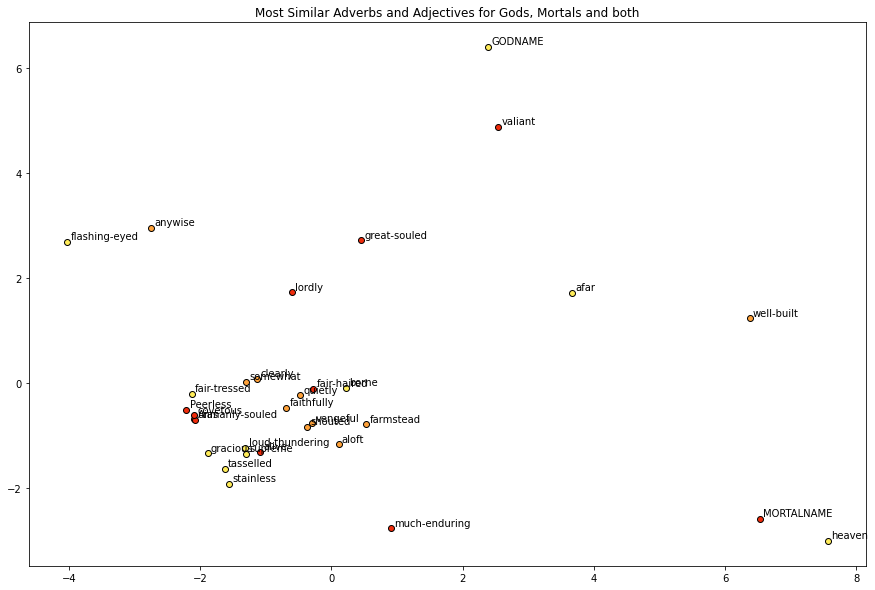

In [39]:
plt.figure(figsize=(15,10))
def display_pca_scatterplot(model, color, words, sample=0):
     
    word_vectors = np.array([model[w] for w in words])

    # do PCA on the selected embeddings
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c=color)
    
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

# plot words similar to mortals
display_pca_scatterplot(model.wv, '#EF2C0C',
                        ['MORTALNAME']+[x[0] for x in similarm[:10]])
    
# plot words similar to gods
display_pca_scatterplot(model.wv, '#FFEC59',
                        ['GODNAME']+[x[0] for x in similarg[:10]])

# plot words similar to both mortals and gods
display_pca_scatterplot(model.wv, '#FFA23A',
                        similarGM[:10])

plt.title("Most Similar Adverbs and Adjectives for Gods, Mortals and both")

## Co-occurrences

In the previous Word2Vec model, we grouped all mortals together into MORTALNAME, and all gods into GODNAME. Now, we will use a method with which we can have a look at the seperate characters. We will count the co-occurrences of all the names with adjectives and adverbs.

In [35]:
most_common_list = []
coocu = Counter()
for sent in name_cons:
       
    target = sent[0]
    con = sent[1]
    filteredcon = []
       
    for word in con:
        if word[0] in remove:
            continue
        else:
            filteredcon.append(word)

    for conword in filteredcon:
        if conword[1][0:2] in ['RB', 'JJ']:
            
            coocu[(target[0], conword[0])] += 1

for common in list(coocu.most_common(500)):
    most_common_list.append(common)

In [36]:
# define header names
col_names = ["Character description", "Occurence"]

print(tabulate(most_common_list, headers=col_names))

Character description               Occurence
--------------------------------  -----------
('Odysseus', 'goodly')                    110
('Athena', 'flashing-eyed')                58
('Zeus', 'great')                          42
('Hector', 'goodly')                       40
('Hector', 'glorious')                     33
('Athene', 'flashing-eyed')                31
('Menelaus', 'fair-haired')                30
('Menelaus', 'good')                       27
('Hera', 'white-armed')                    25
('Odysseus', 'dear')                       24
('Hera', 'queenly')                        22
('Zeus', 'borne')                          21
('Zeus', 'high')                           20
('Aias', 'great')                          20
('Diomedes', 'good')                       20
('Aias', 'Telamonian')                     19
('Priam', 'old')                           18
('Menelaus', 'glorious')                   17
('Hector', 'great')                        16
('Bacchus', 'Tyrrhenian')         

As can be seen from the above table, most of the common characters are described with very positive adjectives and adverbs, like great and good. We will also take this list and divide the frequencies by the frequency of the character names, to account for the fact that some names are much more common than others. 

In [42]:
most_common_relative = []

for pair in most_common_list:
    name = pair[0][0]
    desc = pair[0][1]
    count = pair[1]
    
    # divide counts by the frequency of the characters
    for godname in goddict.keys():
        if name == goddict[godname][0][0]:
            value = count/goddict[godname][1]
            
    for mortalname in mortaldict.keys():
        if name == mortaldict[mortalname][0][0]:
            value = count/mortaldict[mortalname][1]
            
    most_common_relative.append([[name, desc], value])

# sort list
most_common_relative = sorted(most_common_relative, key=lambda x: x[1], reverse=True)

print(tabulate(most_common_relative, headers=col_names))

Character description               Occurence
--------------------------------  -----------
['Briseis', 'fair-cheeked']        0.470588
['Demodocus', 'clear-toned']       0.363636
['Tithonus', 'lordly']             0.333333
['Eurycleia', 'dear']              0.32
['Eurycleia', 'nurse']             0.32
['Orestes', 'goodly']              0.272727
['Capaneus', 'glorious']           0.272727
['Hector', 'greatly']              0.272727
['Capaneus', 'good']               0.272727
['Bellerophon', 'peerless']        0.272727
['Agenor', 'goodly']               0.25
['Hector', 'long']                 0.25
['Jove', 'great']                  0.25
['Aegisthus', 'guileful']          0.230769
['Oeneus', 'noble']                0.222222
['Orion', 'alone']                 0.2
['Alcinous', 'hard']               0.2
['Peirithous', 'glorious']         0.2
['Oïleus', 'swift']                0.190476
['Iris', 'wind-footed']            0.181818
['Orestes', 'noble']               0.181818
['Orestes', 'far-fa

From this table, we can also see that most characters are related to positive descriptors. There are some characters with more neutral or negative descriptors (like Laodamas and alone, or Laomedon and old), but most adjectives and adverbs are still positive. What further stands out is that many descriptors are very character-specific. For example, Hector is described with the words 'horse-taming' (relative count 0.0413793) and 'man-slaying' (relative count 0.0594406). These are quite specific descriptors which connect well to the character, since in an important scene of the Iliad, Hector kills Achilles's best friend Patroclus, ties him to his horse cart and rides around in the cart (one of Patroclus's descriptors is 'dead', which also makes sense considering this story). The descriptors of man-slaying and horse-taming are much less common for other characters. Another descriptor that is specific to a character is 'loud-thundering' for Zeus (relative count 0.00404848). Zeus is the god of thunder, which is why this specific adjective is used for him. Hera is also mentioned with 'loud-thundering', but this may be because Hera is often mentioned together with Zeus in one sentence. In this case, the context of Hera may slightly overlap with that of Zeus, leading to Hera being described as loud-thundering. So, what we see from these results is that there are a few descriptors that are very commonly used for both mortals and gods. Furthermore, there are many other descriptors that are specific for a certain character and describe only them.

All in all, mortals and gods in Greek mythology are described more similarly than expected. Both positive and negative descriptors are used for them, but the majority of adjectives and adverbs around them are positive. The largest differences may be between specific characters, in stead of between the general group of gods and the general group of mortals. This analysis helps in further understanding how mortals and gods in Greek mythology relate to each other, and as such may provide a deeper understanding of ancient Greek culture.